# Imports

In [15]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import joblib
import os.path
from messaging.telegrambot import Bot
import telegram
import sys
sources_path = './../Sources'
if sources_path not in sys.path:
    sys.path.append(sources_path)
from Evaluations.metrics import MSE, RMSE, MAE
from Environment import io
from Recommender import recsys
from 
import os
#sys.path.append('../Sources') # Adding my own libs source
#from StackedAutoEncoderRS.SAERS import SAE

In [16]:
reload(io)

<module 'Environment.io' from './../Sources/Environment/io.py'>

# Defining Constant Variables

In [5]:
%matplotlib inline
results_path = './Results/'
verbose = True

# Loading Dataset

In [6]:
#Loading dataset

dataset = '100k/' #100k dataset path
#dataset = '10M/' #10M dataset path
#dataset = '20M/' #20M dataset path

dataset_path = '../../Datasets/movieLens/' + dataset; # Full dataset path

filenames = {'movie': 'movie.csv', 'rating': 'rating.csv'};

time_zero = time.time();
#df_movies = pd.read_csv(dataset_path+filenames['movie'], error_bad_lines=False);
#print "[Loading Time:",time.time()-time_zero,"s]",filenames['movie'],'Shape: ', df_movies.shape;

#print df_movies.head();
#print df_movies.tail();

df_ratings = pd.read_csv(dataset_path+filenames['rating']);
print "[Loading Time:",time.time()-time_zero,"s]",filenames['rating'],'Shape: ', df_ratings.shape;


[Loading Time: 0.0312979221344 s] rating.csv Shape:  (100000, 4)


In [7]:
df_ratings.head()

,userId,itemId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


# Creating Recommender Class

# Creating Recommender Instance

In [9]:
%%time
reload(recsys)
rs = recsys.recommender(algorithm = 'knnbasic')
print rs.get_name()
rs.fit(df_ratings = df_ratings, 
       k = 40,
       n_epochs = 10, 
       n_factors = 40, 
       columns = ['userId', 'itemId', 'rating', 'timestamp'],
       verbose = True)

knnbasic
Using default k_min: 1
Computing the msd similarity matrix...
Done computing similarity matrix.
CPU times: user 587 ms, sys: 30.2 ms, total: 617 ms
Wall time: 620 ms


# Getting Predictions for a Single User

In [10]:
#rs.get_top_n(10)
#rs.get_model()
print (rs.predict(userId = 196, itemId = 242))

3.80140738488


## Getting Predictions of Unknown Ratings

In [ ]:
#rs.calculate_unknown_prediction()

In [ ]:
%%time
#df_unknown_predictions = rs.get_unknown_predictions(calculate_predictions = False)

## Getting Predictions of Known Ratings

In [ ]:
%%time
df_known_predictions = rs.get_known_predictions(calculate_predictions = False)

In [ ]:
df_known_predictions.head()

## Building users topN Recommendation

In [ ]:
%%time
known_sequences = rs.get_top_n(n=10, source = 'known', calculate_sequence = True)

In [ ]:
print (len(known_sequences))
#known_sequences

## Evaluating Algorithm

In [ ]:
print (MSE(df_known_predictions['rating'], df_known_predictions['prediction']))
print (RMSE(df_known_predictions['rating'], df_known_predictions['prediction']))
print (MAE(df_known_predictions['rating'], df_known_predictions['prediction']))

df_known_predictions.head()

## Evaluating Number of Neighbours on KNN-Based-Algorithms

In [ ]:
%%time
knn_based_algorithms = ['knnbasic', 'kmeans']
k_array = np.arange(1, 301, 5)

for algorithm in knn_based_algorithms:    
    time_zero = time.time()
    rs = recsys.recommender(algorithm = algorithm)
    print ("----------------------------------------------------")
    print ("Calculating evaluations for {}".format(rs.get_name()))
    
    #knn_predictions = dict()
    k_evaluations = dict()
    
    for k in k_array:            
        # Fitting Algorithm
        rs.fit(df_ratings = df_ratings, k = k, verbose = False)
        
        # Getting Known Predictions
        df_known_predictions = rs.get_known_predictions(calculate_predictions = True)
        
        # Evaluating Known Predictions
        mae = MAE(df_known_predictions['rating'], df_known_predictions['prediction'])
        rmse = RMSE(df_known_predictions['rating'], df_known_predictions['prediction'])
        mse = MSE(df_known_predictions['rating'], df_known_predictions['prediction'])
        
        k_evaluations[k] = {'mae': mae, 'rmse': rmse, 'mse': mse}
        
    # Saving evaluations
    saveVariable(results_path = results_path, dataset = dataset, variable = k_evaluations, filename = '{}_evaluations_dic'.format(algorithm), verbose = True)
    print ("Elapsed time for {}: {}".format(rs.get_name(), time.time()-time_zero))

----------------------------------------------------
Calculating evaluations for knnbasic
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matri

Loading variable from ./Results/Variables/100k/knnbasic_evaluations_dic
Variable loaded
[*] Saving plot to {} folder ./Results/Figures/100k/knnbasic_evaluations_per_neighbours.png
[+] Results saved.
Loading variable from ./Results/Variables/100k/kmeans_evaluations_dic
Variable loaded
[*] Saving plot to {} folder ./Results/Figures/100k/kmeans_evaluations_per_neighbours.png
[+] Results saved.


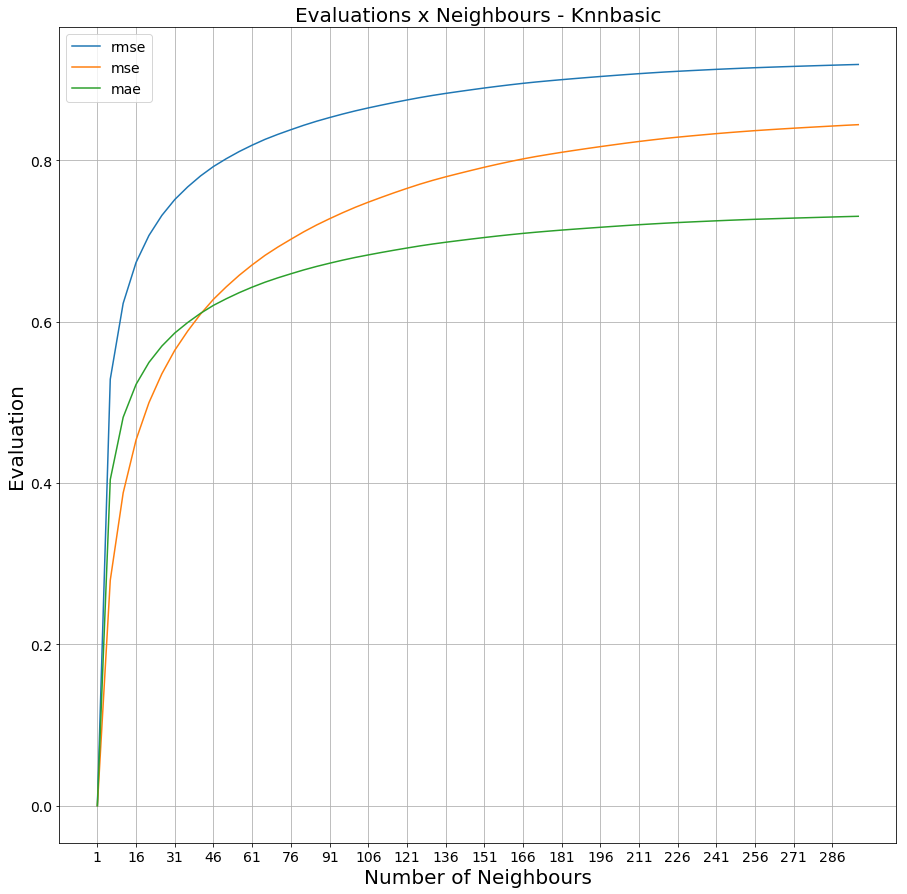

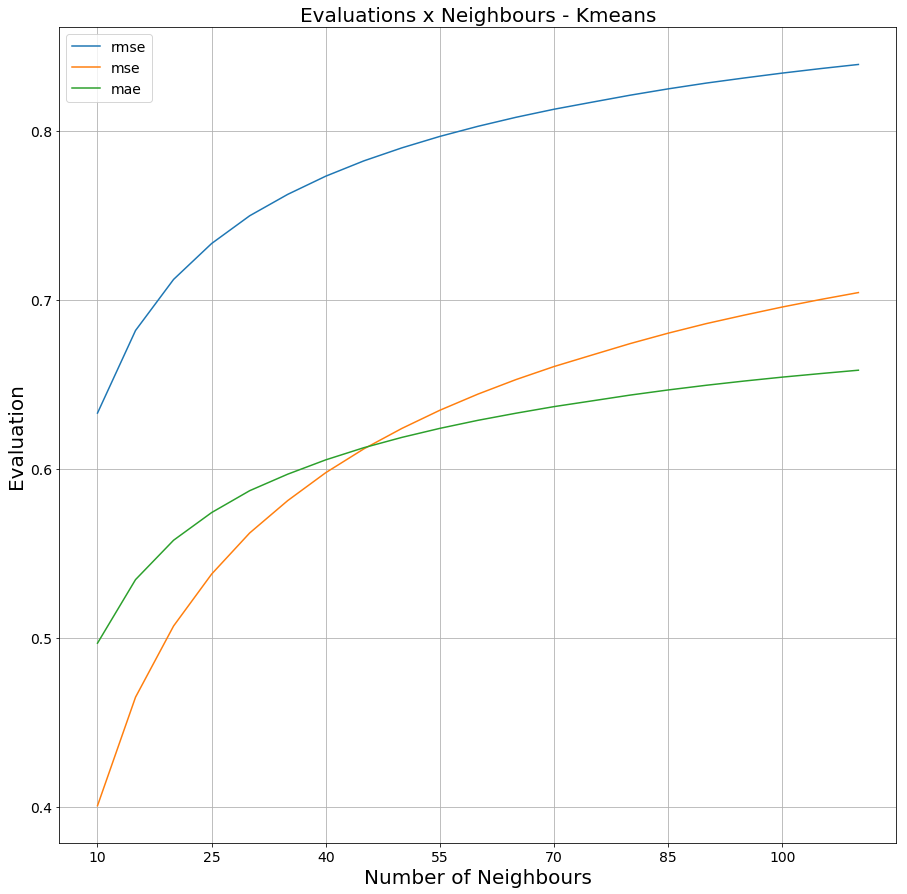

In [26]:
# Loading algorithm evaluations variable
for algorithm in knn_based_algorithms:
    #algorithm = 'kmeans'#'knnbasic'
    k_evaluations = loadVariable(results_path=results_path, dataset = dataset, filename = '{}_evaluations_dic'.format(algorithm), verbose = verbose)

    # Converting Dictionary to array
    k_array = np.array([])
    rmse_array = np.array([])
    mae_array = np.array([])
    mse_array = np.array([])

    for key in sorted(k_evaluations.keys()):
        k_array = np.append(k_array, int(key))
        rmse_array = np.append(rmse_array, k_evaluations[key]['rmse'])
        mse_array = np.append(mse_array, k_evaluations[key]['mse'])
        mae_array = np.append(mae_array, k_evaluations[key]['mae'])

    # Plotting Evaluations
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.plot(k_array, rmse_array, label = 'rmse')
    ax.plot(k_array, mse_array, label = 'mse')
    ax.plot(k_array, mae_array, label = 'mae')
    #ax.axis([0, k_array[-1], 0, itemsQuantity[-1]])
    ax.grid(True)
    ax.legend(fontsize = 14)
    ax.set_xticks([x for x in xrange (int(k_array[0]), int(k_array[-1])+1, 15)])
    #ax.set_yticks([x for x in xrange (0, itemsQuantity[-1], 100)])

    ax.set_xlabel('Number of Neighbours', fontsize = 20)
    ax.set_ylabel('Evaluation', fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title('Evaluations x Neighbours - {}'.format(algorithm.title()), fontsize = 20)

    io.saveFigure(results_path, dataset, '{}_evaluations_per_neighbours.png'.format(algorithm), fig, verbose = True)

## Evaluating Number of Factors on Matrix Factorization-based Algorithms

In [ ]:
%%time
matrix_factorization_based_algorithms = ['svd']
n_factors_array = np.arange(70, 311, 20)


for algorithm in matrix_factorization_based_algorithms:    
    time_zero = time.time()
    rs = recsys.recommender(algorithm = algorithm)
    print ("----------------------------------------------------")
    print ("Calculating evaluations for {}".format(rs.get_name()))
    
    matrix_factorization_evaluations = dict()
    
    for n_factors in n_factors_array:            
        # Fitting Algorithm
        rs.fit(df_ratings = df_ratings, n_factors = n_factors, verbose = False)
        
        # Getting Known Predictions
        df_known_predictions = rs.get_known_predictions(calculate_predictions = True)
        
        # Evaluating Known Predictions
        mae = MAE(df_known_predictions['rating'], df_known_predictions['prediction'])
        rmse = RMSE(df_known_predictions['rating'], df_known_predictions['prediction'])
        mse = MSE(df_known_predictions['rating'], df_known_predictions['prediction'])
        
        matrix_factorization_evaluations[n_factors] = {'mae': mae, 'rmse': rmse, 'mse': mse}
        
    # Saving evaluations
    saveVariable(results_path = results_path, dataset = dataset, variable = matrix_factorization_evaluations, filename = '{}_evaluations_dic'.format(algorithm), verbose = True)
    print ("Elapsed time for {}: {}".format(rs.get_name(), time.time()-time_zero))

In [ ]:
# Loading algorithm evaluations variable
for algorithm in matrix_factorization_based_algorithms:
    #algorithm = 'kmeans'#'knnbasic'
    n_factors_evaluations = loadVariable(results_path=results_path, dataset = dataset, filename = '{}_evaluations_dic'.format(algorithm), verbose = verbose)

    # Converting Dictionary to array
    n_factors_array = np.array([])
    rmse_array = np.array([])
    mae_array = np.array([])
    mse_array = np.array([])

    for key in sorted(n_factors_evaluations.keys()):
        n_factors_array = np.append(n_factors_array, int(key))
        rmse_array = np.append(rmse_array, n_factors_evaluations[key]['rmse'])
        mse_array = np.append(mse_array, n_factors_evaluations[key]['mse'])
        mae_array = np.append(mae_array, n_factors_evaluations[key]['mae'])

    # Plotting Evaluations
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(n_factors_array, rmse_array, label = 'rmse')
    ax.plot(n_factors_array, mse_array, label = 'mse')
    ax.plot(n_factors_array, mae_array, label = 'mae')
    #ax.axis([0, k_array[-1], 0, itemsQuantity[-1]])
    ax.grid(True)
    ax.legend(fontsize = 14)
    ax.set_xticks([x for x in xrange (int(n_factors_array[0]), int(n_factors_array[-1])+1, 20)])
    #ax.set_yticks([x for x in xrange (0, itemsQuantity[-1], 100)])

    ax.set_xlabel('Number of Factors', fontsize = 20)
    ax.set_ylabel('Evaluation', fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title('Evaluations x Number of Factors - {}'.format(algorithm.title()), fontsize = 15)

    saveFigure(results_path, dataset, '{}_evaluations_per_factors.png'.format(algorithm), fig, verbose = True)